In [43]:
import pandas as pd

df = pd.read_csv('clean_data.csv')

In [44]:
df

,Unnamed: 0,patient_id,age,diagnosis,hb,ga_weeks,prvs_lscs,meconium,iugr,gdm,...,upd_col_PPROM,upd_col_PROM,upd_col_PREECLAMPSIA,upd_col_OBSTRICAL,upd_cervix_length,upd_afi,efw_upd,fetus_type_THREE,fetus_type_TWIN,delivery_mode_NVD
0,0,0,39.0,['G2P1L1 WITH CHRONIC WITH HTN WITH PREV LSCS'...,10.6,37.0,1.0,0.0,0.0,0.0,...,0,0,0,0,3.45,15.4,3044.000000,0,0,0
1,1,1,32.0,['G3P1L1 AT 37 WKS 5 DAYS POG WITH CHRONIC HTN...,9.3,37.0,1.0,0.0,0.0,0.0,...,0,0,0,0,3.60,10.1,2176.000000,0,0,0
2,2,2,31.0,['PRIMI GRAVIDA AT 37 WKS 6 DAYS POG WITH OLIG...,10.3,37.0,0.0,0.0,0.0,0.0,...,0,0,0,0,3.45,6.4,3110.000000,0,0,0
3,3,3,28.0,['PRIMI GRAVIDA AT 37 WKS 1 DAYS POG WITH HYPO...,12.2,37.0,0.0,0.0,0.0,0.0,...,0,1,0,0,3.40,9.3,1370.000000,0,0,1
4,4,4,31.0,['PRIMI AT 37 WKS 2 DAYS POGFOR SAFE CONFINEME...,11.1,37.0,0.0,0.0,0.0,0.0,...,0,0,0,0,4.30,10.9,2862.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,741,741,22.0,['PRIMI GRAVIDA AT 25 WKS 2 DAYS POG WITH CETR...,10.8,25.0,0.0,0.0,0.0,0.0,...,0,0,0,0,4.80,14.0,333.000000,0,0,0
742,742,742,29.0,['PRIMI GRAVIDA AT 25 WKS 1 DAYS POG WITH OT C...,10.8,25.0,0.0,0.0,0.0,0.0,...,0,0,0,0,4.10,5.5,495.828893,0,0,1
743,743,743,32.0,['PRIMI AT 25 WKS 2 DAYS POG WITH MISSED ABO...,11.1,25.0,0.0,0.0,0.0,0.0,...,0,0,0,0,4.10,4.1,622.195534,0,0,1
744,744,744,32.0,['PRIMI GRAVIDA AT TWIN PREGA PCDA AT 23 WKS ...,11.5,23.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1.60,11.1,714.000000,0,1,1


In [45]:
data_cleaned = df.copy(deep=True)

In [46]:
import re
import string

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    return text

data_cleaned['diagnosis'] = data_cleaned['diagnosis'].apply(preprocess_text)

In [47]:
from transformers import BertTokenizer, BertModel

#bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [55]:
# bio bert
model_name = 'dmis-lab/biobert-v1.1'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [56]:
import torch

def create_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=30)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


data_cleaned['bert_embed'] = data_cleaned['diagnosis'].apply(create_bert_embeddings)

In [57]:
# Convert the 'bert_embed' column to a DataFrame
from sklearn.model_selection import train_test_split


embeddings_df = pd.DataFrame(data_cleaned['bert_embed'].tolist())

from sklearn.decomposition import PCA

# Assuming 'features_df' is your DataFrame containing both numerical features and BERT embeddings

# Initialize PCA to cover 90% of variance
pca = PCA(n_components=0.75, svd_solver='full')
features_reduced = pca.fit_transform(embeddings_df)


# Drop the 'diagnosis' column and any other non-numerical or unnecessary columns from the original dataset
numerical_features = data_cleaned.drop(columns=['diagnosis', 'bert_embed', 'Unnamed: 0', 'patient_id'])

# Concatenate the numerical features with the embeddings
features_df = pd.concat([numerical_features.reset_index(drop=True), pd.DataFrame(features_reduced)], axis=1)

# Define your target variable
y = data_cleaned['delivery_mode_NVD']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df.drop(columns=['delivery_mode_NVD']), y, test_size=0.2, random_state=42)


In [50]:
X_train

,age,hb,ga_weeks,prvs_lscs,meconium,iugr,gdm,hyperthyraidisim,kg_upd,height_upd,...,4,5,6,7,8,9,10,11,12,13
70,34.0,11.100000,37.0,1.0,0.0,0.0,0.0,0.0,76.008349,1.567239,...,-1.301718,-0.842871,-0.058733,-1.102493,0.005102,-0.490729,-0.624395,-0.282619,0.312918,0.244469
164,35.0,11.100000,39.0,1.0,0.0,0.0,0.0,1.0,68.000000,0.680000,...,0.423888,1.408062,-0.447770,0.159829,-0.099112,0.292847,-0.351706,-0.442279,0.450415,0.364956
710,28.0,11.245976,35.0,1.0,0.0,0.0,0.0,1.0,70.000000,0.700000,...,0.418081,1.498490,-0.841809,0.294324,1.087934,0.824443,0.259741,-0.470961,0.932533,0.818253
265,21.0,10.200000,39.0,0.0,0.0,0.0,0.0,0.0,52.000000,0.520000,...,-0.608040,-0.086437,-1.175820,-0.103947,-0.291352,-0.388763,-0.581232,-0.094407,-0.158025,-0.668243
250,21.0,11.400000,39.0,0.0,0.0,0.0,0.0,1.0,61.918777,1.508156,...,-1.219058,-0.397398,-0.022834,0.269787,-0.247890,-0.707560,-0.304443,0.030027,-0.096974,-1.348366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,37.0,10.600000,37.0,1.0,0.0,0.0,0.0,0.0,64.000000,0.640000,...,1.433396,0.266250,-0.701391,-0.749655,-0.015129,1.360815,-0.549877,0.308489,-0.244047,-0.547919
106,35.0,11.100000,37.0,0.0,0.0,0.0,0.0,0.0,75.000000,0.750000,...,-0.079658,0.499881,-0.433998,-0.688417,0.157763,0.150916,-1.377450,-0.049865,0.042119,0.438212
270,28.0,14.100000,39.0,0.0,0.0,0.0,0.0,0.0,72.000000,0.720000,...,0.842714,0.999833,-0.163148,-0.327867,-0.501315,-0.963137,-0.622850,-0.598919,0.187195,0.224564
435,32.0,11.100000,40.0,0.0,0.0,0.0,0.0,0.0,75.000000,0.750000,...,-2.514858,0.975654,-0.187784,-0.646547,0.517685,0.403436,0.064064,-0.198216,0.265927,0.389449


In [58]:
X_train

,age,hb,ga_weeks,prvs_lscs,meconium,iugr,gdm,hyperthyraidisim,kg_upd,height_upd,...,4,5,6,7,8,9,10,11,12,13
70,34.0,11.100000,37.0,1.0,0.0,0.0,0.0,0.0,76.008349,1.567239,...,0.035353,-0.425838,0.248379,0.699343,-0.392061,0.237834,-0.689927,-0.205147,-0.354261,-0.124985
164,35.0,11.100000,39.0,1.0,0.0,0.0,0.0,1.0,68.000000,0.680000,...,0.617182,-0.119681,0.433724,-0.405809,0.337531,-0.358713,0.330950,0.171395,-0.259409,-0.012614
710,28.0,11.245976,35.0,1.0,0.0,0.0,0.0,1.0,70.000000,0.700000,...,0.160915,-0.098969,0.523306,-0.099611,0.132238,-1.373878,-0.152895,-0.519596,-0.125762,0.551868
265,21.0,10.200000,39.0,0.0,0.0,0.0,0.0,0.0,52.000000,0.520000,...,-0.261572,0.675048,0.108882,-0.586075,-0.668373,-0.197119,1.179410,-0.334582,-0.520159,-0.570934
250,21.0,11.400000,39.0,0.0,0.0,0.0,0.0,1.0,61.918777,1.508156,...,-0.941632,0.078198,0.148991,0.741233,-0.604295,1.096816,0.965268,-0.726015,-0.025448,-0.449678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,37.0,10.600000,37.0,1.0,0.0,0.0,0.0,0.0,64.000000,0.640000,...,-0.955279,0.029938,0.644908,-0.562656,0.349060,-0.638293,-0.132345,-0.353705,0.164811,0.287758
106,35.0,11.100000,37.0,0.0,0.0,0.0,0.0,0.0,75.000000,0.750000,...,-0.700779,0.804623,-0.393597,0.715375,-0.245138,0.587334,-0.806552,-0.434292,-0.100354,0.069116
270,28.0,14.100000,39.0,0.0,0.0,0.0,0.0,0.0,72.000000,0.720000,...,1.053929,-0.508952,0.249782,0.121344,-0.293951,-0.157489,0.750735,-0.326554,0.436950,0.316216
435,32.0,11.100000,40.0,0.0,0.0,0.0,0.0,0.0,75.000000,0.750000,...,0.013320,-0.000521,1.047793,-0.367931,-0.186360,-0.575158,-0.051306,0.128639,-0.409154,-0.560250


In [59]:

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 11, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3, verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)



{'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['log2', 'sqrt'], 'max_depth': [5, 6, 7, 8, 9, 11, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warn

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 9, 11, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

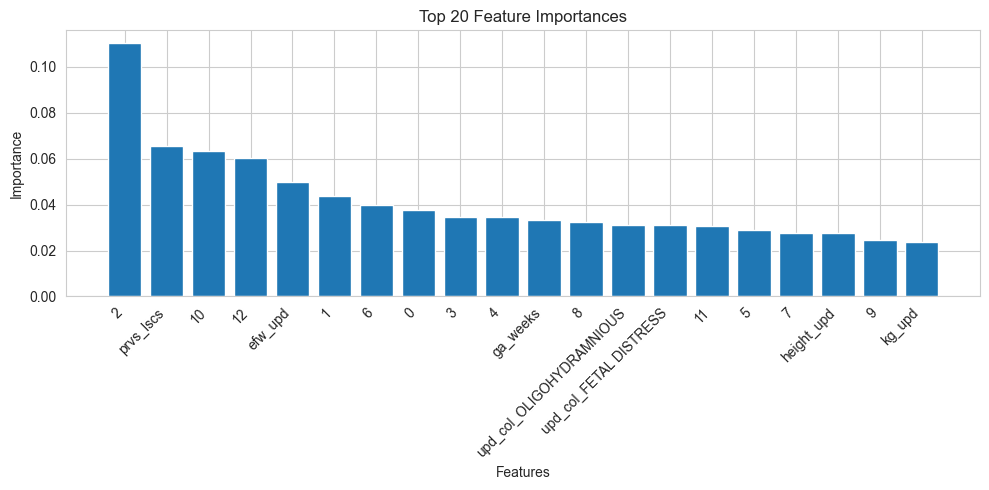

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming best_random, feature_names, and X_train are already defined
best_random = rf_random.best_estimator_
feature_names = X_train.columns.tolist()
# Get feature importances
importances = best_random.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Get the feature names, sorted by importance
names = [feature_names[i] for i in indices]

# Number of features to display
num_features = 20

# Limit the data to the top 'num_features' features
sorted_importances = importances[indices[:num_features]]
sorted_names = [names[i] for i in range(num_features)]

# Create the plot
plt.figure(figsize=(10, 5))
plt.title("Top 20 Feature Importances")
plt.bar(range(num_features), sorted_importances)
plt.xticks(range(num_features), sorted_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and a title
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()  # Adjust subplot parameters to give the plot more room
plt.show()

/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


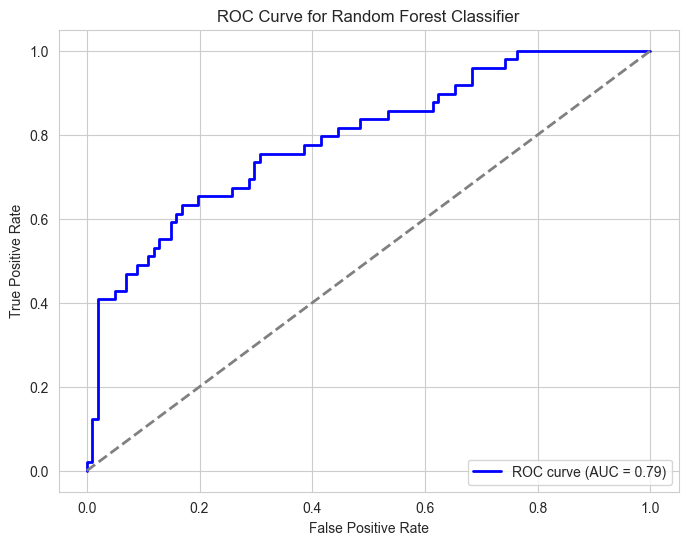

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = best_random.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/Users/pthatoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


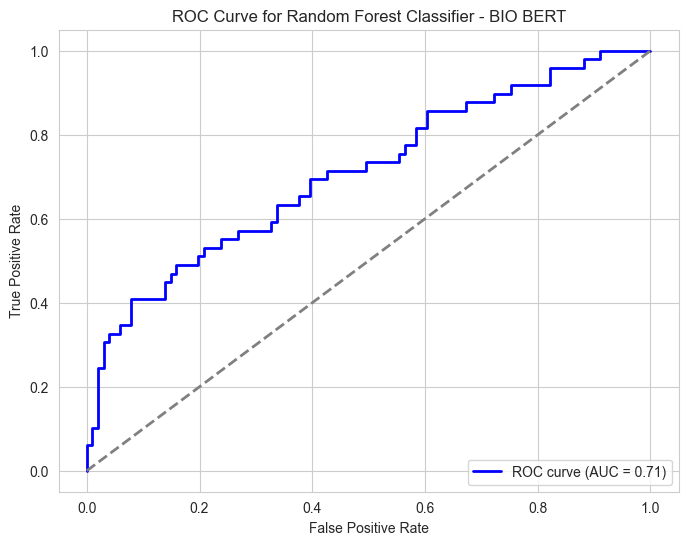

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_proba = best_random.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier - BIO BERT')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()